In [1]:
import block_methods as BM

from Lanczos_FA.lanczos_bin import *

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import integrate

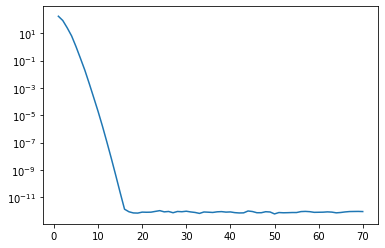

In [2]:
k = 100
b = 2
n = k*b
itr = 70

H = BM.randHerm(n, 1)
V = BM.randVec(n, b)
    
error = BM.mkplt(H, V, itr, b, BM.exp)

In [3]:
def get_a_posteriori_bound(f,gamma,endpts,a_,b_,w,lmin,lmax):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,w,z}| Q_{w,z} |dz|
    """
    
    theta = sp.linalg.eigvalsh_tridiagonal(a_,b_,tol=1e-30)

    def F(t):
        z,dz = gamma(t)
        
        return (1/(2*np.pi)) * np.abs(f(z)) * np.abs(np.prod((theta-w)/(theta-z))) * Q_wz(w,z,lmin,lmax) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200) 
    
    return integral

def Q_wz(w,z,lmin,lmax):
    """
    max_{x\in[lmin,lmax]} |x-w|/|z-w|
    """
    
    if np.real(z) - w != 0:
        b_hat = ( np.abs(z)**2 - np.real(z)*w ) / (np.real(z) - w)
    else:
        b_hat = np.inf
        
    if lmin < b_hat <= lmax:
        return np.abs((z-w)/np.imag(z))
    else:
        return np.max([np.abs((lmax-w)/(lmax-z)), np.abs((lmin-w)/(lmin-z))])

In [4]:
# def const(t):
#     return 1
# # take eval and evec as input for less work
# def a_posteriori(f, z, b, itr, h, T, w, B):
    
#     """
#     Input
#     -----
    
#     f  : function to integrate over
#     n  : matrix size
#     b  : block size
#     itr  : number of iteration
#     h  : bound of h_(w,z)(H)
    
#     Returns
#     -------
#     value of the contour integral
    
#     """
#     Eval, Evec = np.linalg.eigh(T)
#     Dz = np.diag(Eval-z)
#     Dwinv = np.diag(1/(Eval-w))
#     if b == 1:
#         Cz = -BM.Ei(itr*b, b, itr).T@Evec@Dz@Evec.T@BM.Ei(itr*b, b, 1)*B[0]
#         Cwinv = np.linalg.inv(-BM.Ei(itr*b, b, itr).T@Evec@Dwinv@Evec.T@BM.Ei(itr*b, b, 1)*B[0]) 
#     else:get_cwinvcz(Eval, Evec, z, w, itr, b, B)
#         Cz = -BM.Ei(itr*b, b, itr).T@Evec@Dz@Evec.T@BM.Ei(itr*b, b, 1)@B[0]
#         Cwinv = np.linalg.inv(-BM.Ei(itr*b, b, itr).T@Evec@Dwinv@Evec.T@BM.Ei(itr*b, b, 1)@B[0])
    
# #     print(np.shape(BM.Ei(n, b, k)))
    
#     return np.abs(f(z)) * np.abs(h(z)) * np.abs(np.linalg.norm(Cwinv@Cz))
# def contour_eval(f, contour, endpts, b, itr, h, T, w, B):
    
#     """
#     Input
#     -----
    
#     f  : function to integrate over
#     contour  : a already defined contour
#     endpts  : array of two endpoints for the integral
    
#     Returns
#     -------
#     value of the contour integral
    
#     """
        
#     def F(t):
#         z,dz = contour(t)
#         return a_posteriori(f, z, b, itr, h, T, w, B) * np.abs(dz)
    
    
#     integral = sp.integrate.quad(F, endpts[0], endpts[1], epsabs=0)[0]
#     return (1/(2*np.pi))*integral
# def u_disks(t):
#     z = np.exp(t*1j)
#     dz = 1j*np.exp(t*1j)
#     return z, dz

In [7]:
# test case
n = 1000
lam = np.linspace(1e-2,1e2,n)
b = np.ones(n,dtype=np.longdouble)
b /= np.linalg.norm(b)

lmin = np.min(lam).astype(np.double)
lmax = np.max(lam).astype(np.double)
kappa = lmax / lmin

lmin_ = lmin/2
lmax_ = 2*lmax

w = 0

# norm to measure function approximation and linear system errors
B = lam

K = 200
reorth=True
Q,(a_,b_) = exact_lanczos(lam.astype(np.longdouble),b.astype(np.longdouble),K+1,reorth=reorth)

e1 = np.zeros(K+1)
e1[0] = 1

a_posteriori_bound_circle_approx_spectrum = np.full(K,np.inf)
    
def Gamma(t):


    radius = lmax_ - lmin_/100

    z = radius*np.exp(1j*t)+lmax_
    dz = radius*1j*np.exp(1j*t)
    
    return z,dz

def f(x):
    return np.sqrt(x)

contour_eval(f, Gamma1, [0,np.pi/2], 1, k, const, T[:k, :k], w, b_)
fAb = f(lam)*b

for k in range(1,K):
    a_posteriori_bound_circle_approx_spectrum[k-1] = 2*get_a_posteriori_bound(f,Gamma,[0,np.pi],a_[:k],b_[:k-1],w,lmin_,lmax_)[0]

In [8]:
def get_cwinvcz(Eval, Evec, z, w, itr, b, B):
    Dzinv = np.diag(1/(Eval-z))
    Dwinv = np.diag(1/(Eval-w))
    if b == 1:
        Cz = -BM.Ei(itr*b, b, itr).T@Evec@Dzinv@Evec.T@BM.Ei(itr*b, b, 1)*B[0]
        Cwinv = np.linalg.inv(-BM.Ei(itr*b, b, itr).T@Evec@Dwinv@Evec.T@BM.Ei(itr*b, b, 1)*B[0]) 
    else:
        Cz = -BM.Ei(itr*b, b, itr).T@Evec@Dzinv@Evec.T@BM.Ei(itr*b, b, 1)@B[0]
        Cwinv = np.linalg.inv(-BM.Ei(itr*b, b, itr).T@Evec@Dwinv@Evec.T@BM.Ei(itr*b, b, 1)@B[0])
    
    return np.linalg.norm(Cwinv@Cz)
def block_a_posteriori_bound(f,gamma,endpts,a_,b_,w,lmin,lmax, itr, b, B):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,w,z}| Q_{w,z} |dz|
    """
    
#     make T matrix
    T = np.diag(a_.astype(np.double)) + np.diag(b_.astype(np.double), 1) + np.diag(b_.astype(np.double), -1)
    
    Eval, Evec = np.linalg.eigh(T)

    def F(t):
        z,dz = gamma(t)
        
        return (1/(2*np.pi)) * np.abs(f(z)) * get_cwinvcz(Eval, Evec, z, w, itr, b, B) * Q_wz(w,z,lmin,lmax) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200) 
    
    return integral

In [9]:
# use linear solver as oppose to get inverse
def exact_err(w, H, V, Q, T, B):
    return np.linalg.inv(H-w*np.eye(A.shape[0]))@b-(Q@np.linalg.inv(T-w*np.eye(T.shape[0]))@BM.Ei(K+1, 1, 1)*b_[0]).T

In [10]:
compare = np.full(K,np.inf)

for k in range(1,K):
    compare[k-1] = 2*block_a_posteriori_bound(f,Gamma,[0,np.pi],a_[:k],b_[:k-1],w,lmin_,lmax_, k, 1, b_[:k])[0]
#     *np.linalg.norm(exact_err(w, A, b, Q, T, b_))

/tmp/ipykernel_592178/3137018363.py:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200)
/tmp/ipykernel_592178/3137018363.py:27: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200)


In [12]:
compare-a_posteriori_bound_circle_approx_spectrum

/tmp/ipykernel_592178/3442352566.py:1: RuntimeWarning: invalid value encountered in subtract
  compare-a_posteriori_bound_circle_approx_spectrum


array([ 1.13686838e-13, -2.84217094e-14, -5.32907052e-13, -1.98951966e-13,
       -3.14415161e-13, -8.26005930e-14, -1.63424829e-13, -1.70086167e-13,
       -1.40776280e-13, -1.07247544e-13, -5.70654635e-14, -2.02060590e-14,
        4.54081217e-14,  1.69864123e-14,  7.32747196e-15,  1.76247905e-13,
        9.74775816e-14,  7.28306304e-14,  2.66342504e-13,  1.45133905e-13,
        7.06379399e-14,  9.74220704e-14,  1.86906046e-13,  5.20139487e-14,
        2.07153739e-13,  9.12048215e-14,  2.08721929e-14,  4.43811654e-14,
        3.45140583e-14,  3.74353326e-14,  4.16056078e-14,  4.33403313e-14,
        5.07163755e-14,  2.16354712e-14,  1.10564335e-13,  1.14075416e-14,
        3.10619586e-14,  2.15938378e-14,  7.99985078e-14,  5.10216869e-14,
        4.33472702e-14,  1.05592618e-13,  4.97102359e-14,  9.09845116e-14,
        2.89403917e-14,  2.03413675e-14,  3.55670354e-14,  3.80129955e-14,
        5.97629585e-14,  4.62060945e-14,  7.51655682e-14,  3.74526798e-14,
        3.22389684e-14,  

In [13]:
get_cwinvcz(Eval, Evec, z, w, itr, b, B)

NameError: name 'Eval' is not defined

In [ ]:
np.abs(np.prod((theta-w)/(theta-z)))